In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from datetime import datetime
import holidays
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv('traffic.csv') 
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [7]:
df['DateTime']=pd.to_datetime(df['DateTime'])

df["Year"]=df['DateTime'].dt.year

df["Month"]=df['DateTime'].dt.month

df["Date_no"]=df['DateTime'].dt.day

df["Hour"]=df['DateTime'].dt.hour

df["Day"]= df['DateTime'].dt.strftime("%A")
df

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
 4   Year      48120 non-null  int32         
 5   Month     48120 non-null  int32         
 6   Date_no   48120 non-null  int32         
 7   Hour      48120 non-null  int32         
 8   Day       48120 non-null  object        
dtypes: datetime64[ns](1), int32(4), int64(3), object(1)
memory usage: 2.6+ MB


In [11]:
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
Year        0
Month       0
Date_no     0
Hour        0
Day         0
dtype: int64

<Axes: xlabel='Date_no', ylabel='Vehicles'>

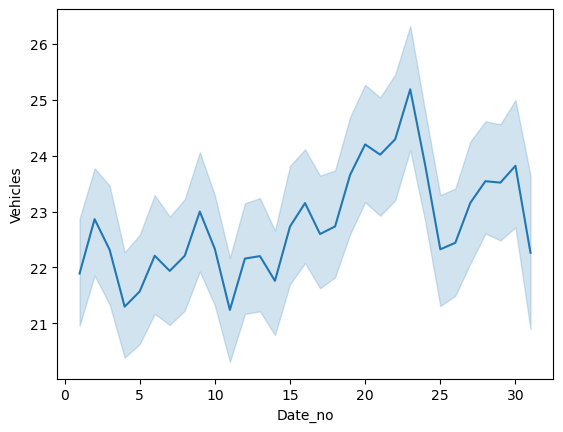

In [13]:
sns.lineplot(x=df['Date_no'],y="Vehicles",data=df)


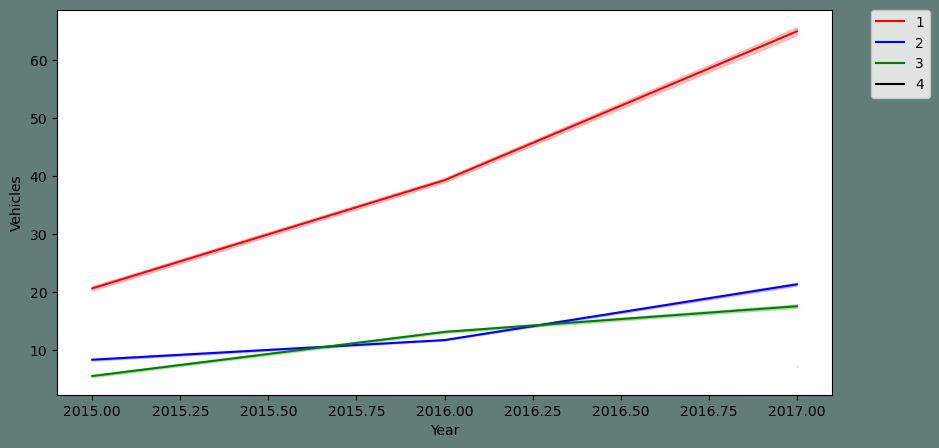

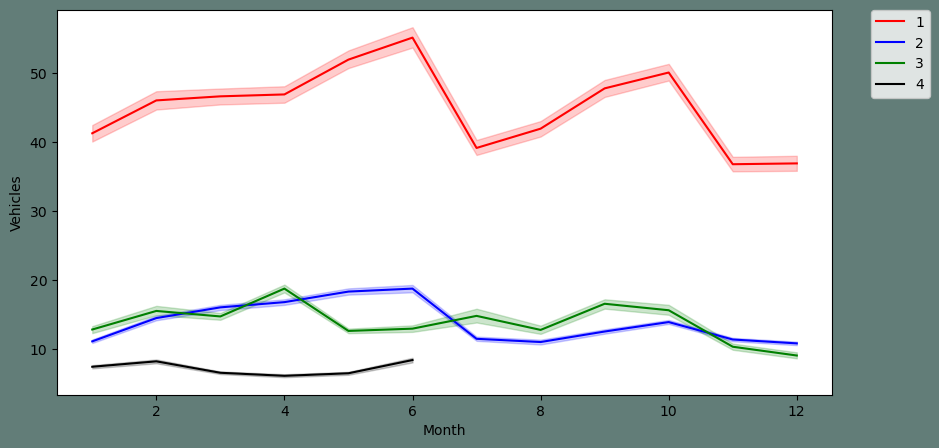

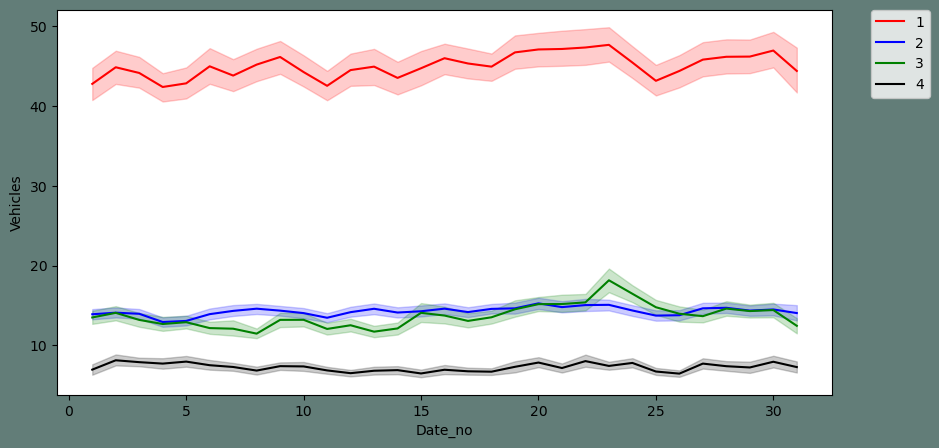

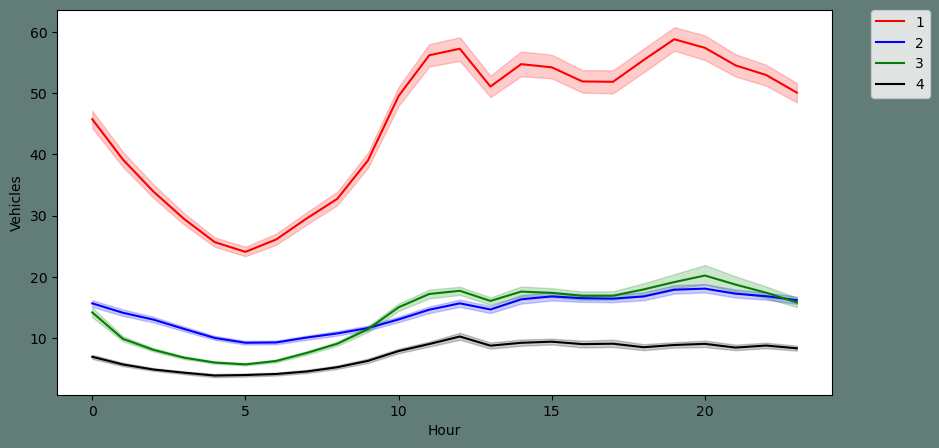

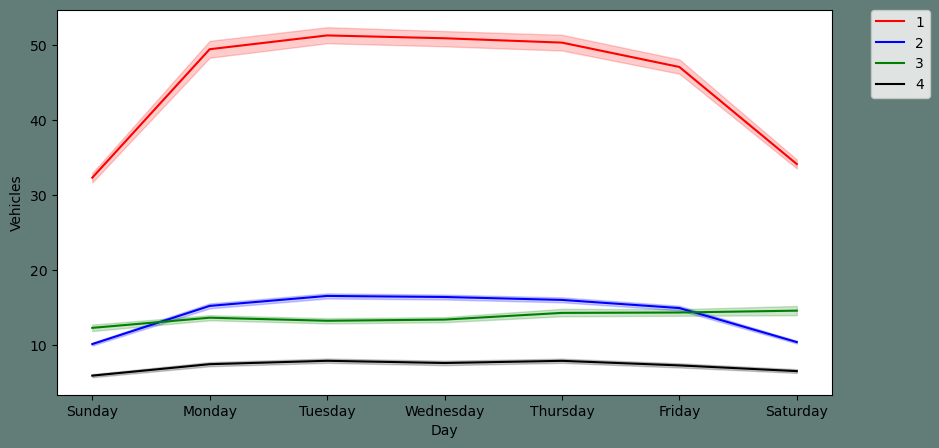

In [15]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,5),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=['red','blue','green','black'] )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

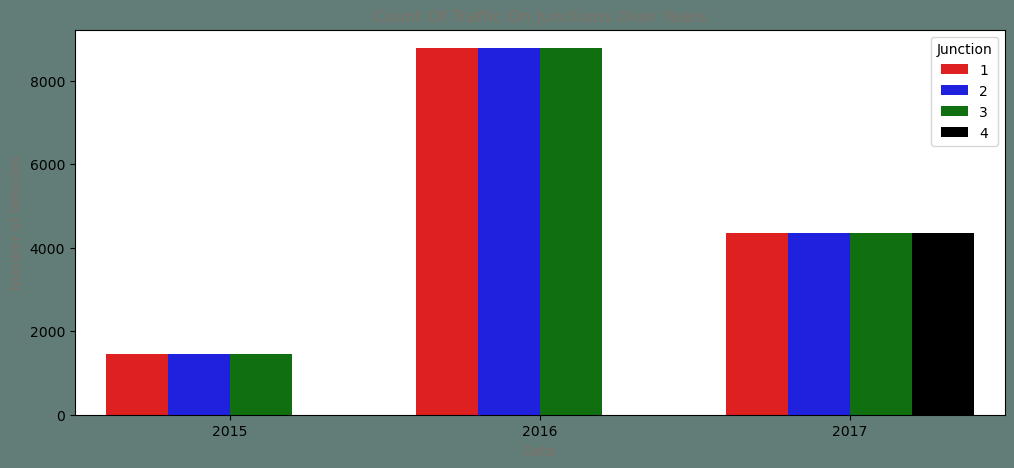

In [22]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=['red','blue','green','black'])
count.set_title("Count Of Traffic On Junctions Over Years", color="#7D7368")
count.set_ylabel("Number of Vehicles", color="#7D7368")
count.set_xlabel("Date", color="#7D7368")

<Axes: >

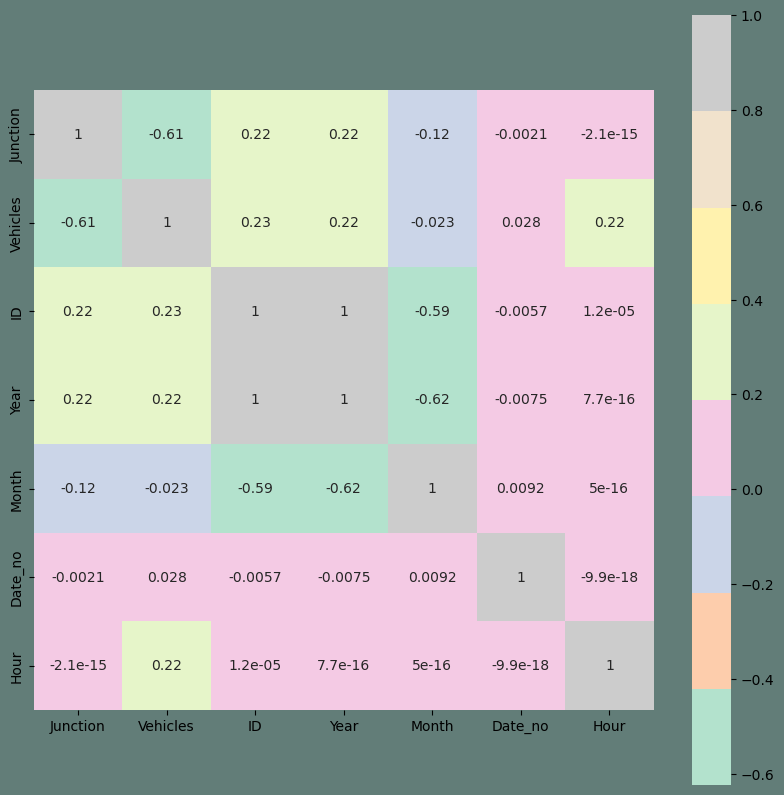

In [16]:
corrmat = df.corr(numeric_only=True)
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

C:\Users\mahes\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


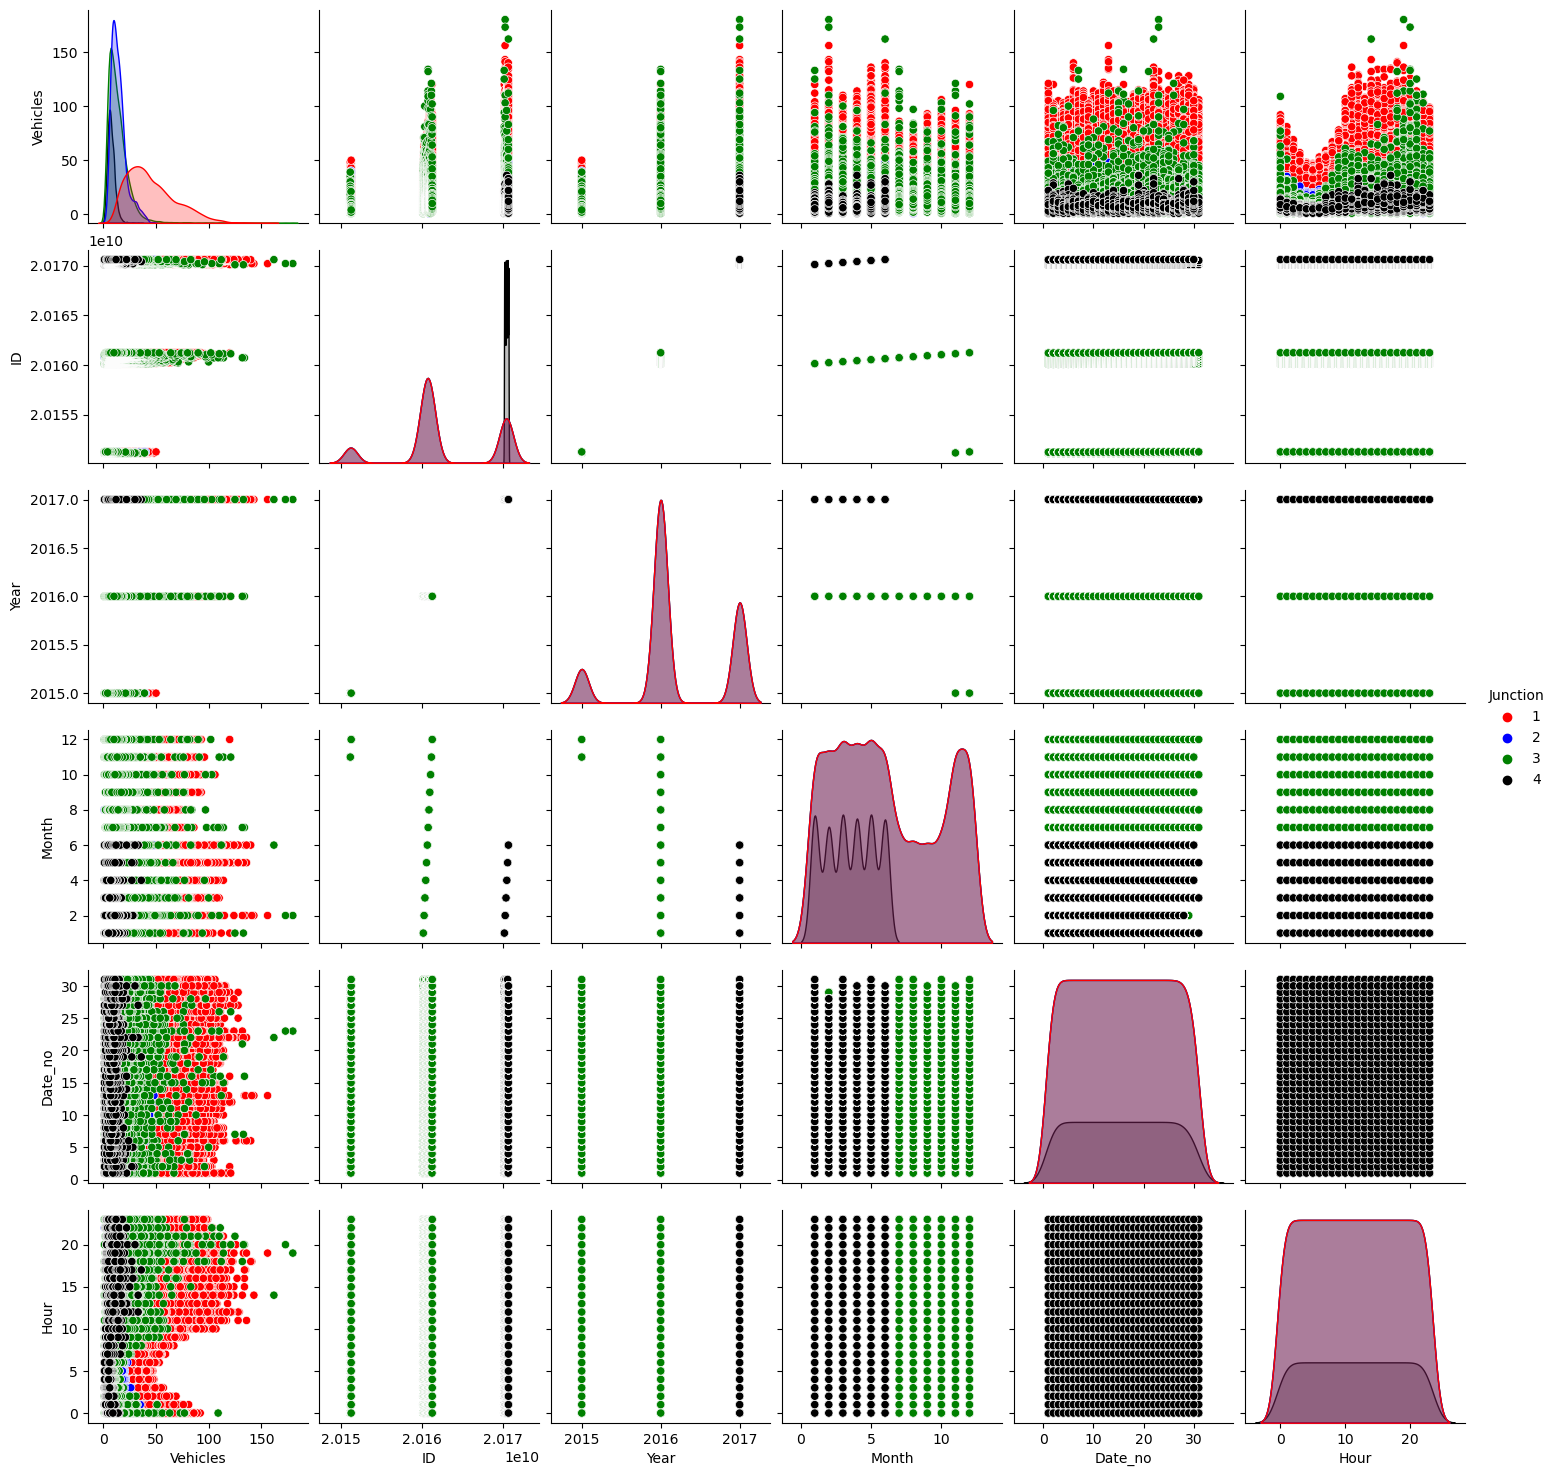

In [31]:
sns.pairplot(data=df, hue= "Junction",palette=['red','blue','green','black'])


In [19]:
df_J = df.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                                     ID  \
Junction             1             2             3            4             1   
count     14592.000000  14592.000000  14592.000000  4344.000000  1.459200e+04   
mean         45.052906     14.253221     13.694010     7.251611  2.016260e+10   
std          23.008345      7.401307     10.436005     3.521455  5.779594e+06   
min           5.000000      1.000000      1.000000     1.000000  2.015110e+10   
25%          27.000000      9.000000      7.000000     5.000000  2.016038e+10   
50%          40.000000     13.000000     11.000000     7.000000  2.016083e+10   
75%          59.000000     17.000000     18.000000     9.000000  2.017013e+10   
max         156.000000     48.000000    180.000000    36.000000  2.017063e+10   

                                                            Year  \
Junction             2             3             4             1   
count     1.459200e+04  1.459200e+04  4.344000e+03  14592.000000   
mean      2.016260e+10  2.016260e+10  2.017037e+10   2016.197368   
std       5.779594e+06  5.779594e+06  1.712987e+05      0.599247   
min       2.015110e+10  2.015110e+10  2.017010e+10   2015.000000   
25%       2.016038e+10  2.016038e+10  2.017022e+10   2016.000000   
50%       2.016083e+10  2.016083e+10  2.017040e+10   2016.000000   
75%       2.017013e+10  2.017013e+10  2.017052e+10   2017.000000   
max       2.017063e+10  2.017063e+10  2.017063e+10   2017.000000   

                        ...         Month                    Date_no  \
Junction             2  ...             3            4             1   
count     14592.000000  ...  14592.000000  4344.000000  14592.000000   
mean       2016.197368  ...      6.120066     3.508287     15.710526   
std           0.599247  ...      3.619842     1.710157      8.789036   
min        2015.000000  ...      1.000000     1.000000      1.000000   
25%        2016.000000  ...      3.000000     2.000000      8.000000   
50%        2016.000000  ...      6.000000     4.000000     16.000000   
75%        2017.000000  ...     10.000000     5.000000     23.000000   
max        2017.000000  ...     12.000000     6.000000     31.000000   

                                                           Hour                \
Junction             2             3            4             1             2   
count     14592.000000  14592.000000  4344.000000  14592.000000  14592.000000   
mean         15.710526     15.710526    15.602210     11.500000     11.500000   
std           8.789036      8.789036     8.736328      6.922424      6.922424   
min           1.000000      1.000000     1.000000      0.000000      0.000000   
25%           8.000000      8.000000     8.000000      5.750000      5.750000   
50%          16.000000     16.000000    16.000000     11.500000     11.500000   
75%          23.000000     23.000000    23.000000     17.250000     17.250000   
max          31.000000     31.000000    31.000000     23.000000     23.000000   

                                     
Junction             3            4  
count     14592.000000  4344.000000  
mean         11.500000    11.500000  
std           6.922424     6.922983  
min           0.000000     0.000000  
25%           5.750000     5.750000  
50%          11.500000    11.500000  
75%          17.250000    17.250000  
max          23.000000    23.000000  

[8 rows x 24 columns]

In [21]:
df.sample(3)

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
22293,2016-09-16 21:00:00,2,13,20160916212,2016,9,16,21,Friday
6866,2016-08-13 02:00:00,1,25,20160813021,2016,8,13,2,Saturday
9136,2016-11-15 16:00:00,1,69,20161115161,2016,11,15,16,Tuesday


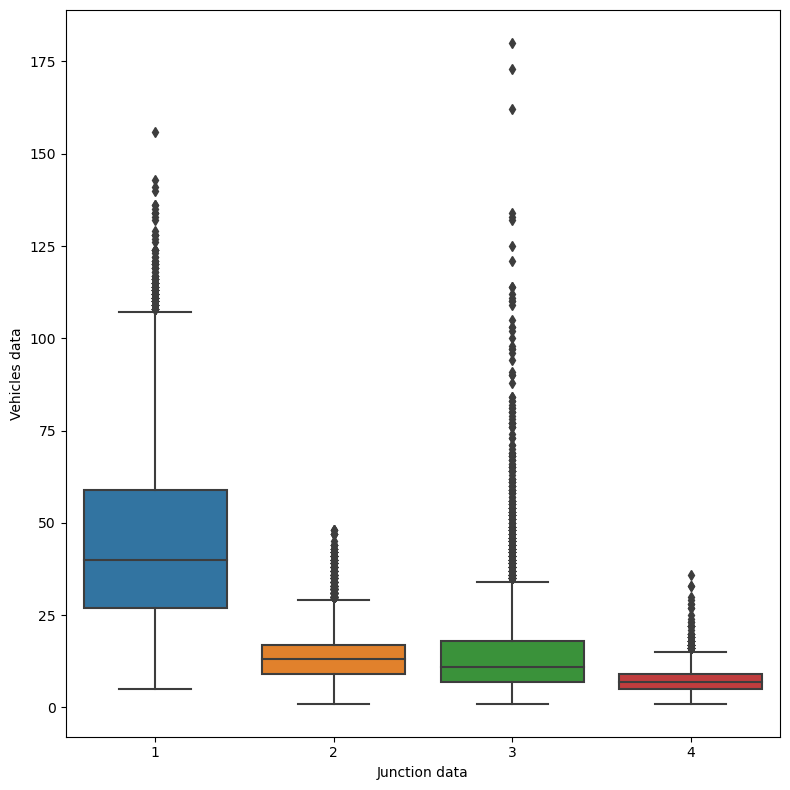

In [23]:
plt.figure(figsize = (8,8))
sns.boxplot(x = df['Junction'], y = df['Vehicles'], data = df)

plt.xlabel('Junction data')
plt.ylabel('Vehicles data')
plt.tight_layout()
plt.show()

In [25]:
df.groupby('Junction')['Vehicles'].describe()

,count,mean,std,min,25%,50%,75%,max
Junction,,,,,,,,
1,14592.0,45.052906,23.008345,5.0,27.0,40.0,59.0,156.0
2,14592.0,14.253221,7.401307,1.0,9.0,13.0,17.0,48.0
3,14592.0,13.694010,10.436005,1.0,7.0,11.0,18.0,180.0
4,4344.0,7.251611,3.521455,1.0,5.0,7.0,9.0,36.0


In [27]:
def z_outliers(data,column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    IQR = Q3-Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 - 1.5*IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Identify outliers for each junction
outliers_junction_1 = z_outliers(df[df['Junction'] == 1] , 'Vehicles')
outliers_junction_2 = z_outliers(df[df['Junction'] == 2] , 'Vehicles')
outliers_junction_3 = z_outliers(df[df['Junction'] == 3] , 'Vehicles')
outliers_junction_4 = z_outliers(df[df['Junction'] == 4] , 'Vehicles')

outliers = pd.concat([outliers_junction_1,outliers_junction_2,outliers_junction_3,outliers_junction_4])

print(outliers)
                  

                 DateTime  Junction  Vehicles           ID  Year  Month  \
0     2015-11-01 00:00:00         1        15  20151101001  2015     11   
1     2015-11-01 01:00:00         1        13  20151101011  2015     11   
9     2015-11-01 09:00:00         1        12  20151101091  2015     11   
10    2015-11-01 10:00:00         1        15  20151101101  2015     11   
11    2015-11-01 11:00:00         1        17  20151101111  2015     11   
...                   ...       ...       ...          ...   ...    ...   
48115 2017-06-30 19:00:00         4        11  20170630194  2017      6   
48116 2017-06-30 20:00:00         4        30  20170630204  2017      6   
48117 2017-06-30 21:00:00         4        16  20170630214  2017      6   
48118 2017-06-30 22:00:00         4        22  20170630224  2017      6   
48119 2017-06-30 23:00:00         4        12  20170630234  2017      6   

       Date_no  Hour     Day  
0            1     0  Sunday  
1            1     1  Sunday  
9     

In [29]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
outliers['DateTime'] = pd.to_datetime(outliers['DateTime'])

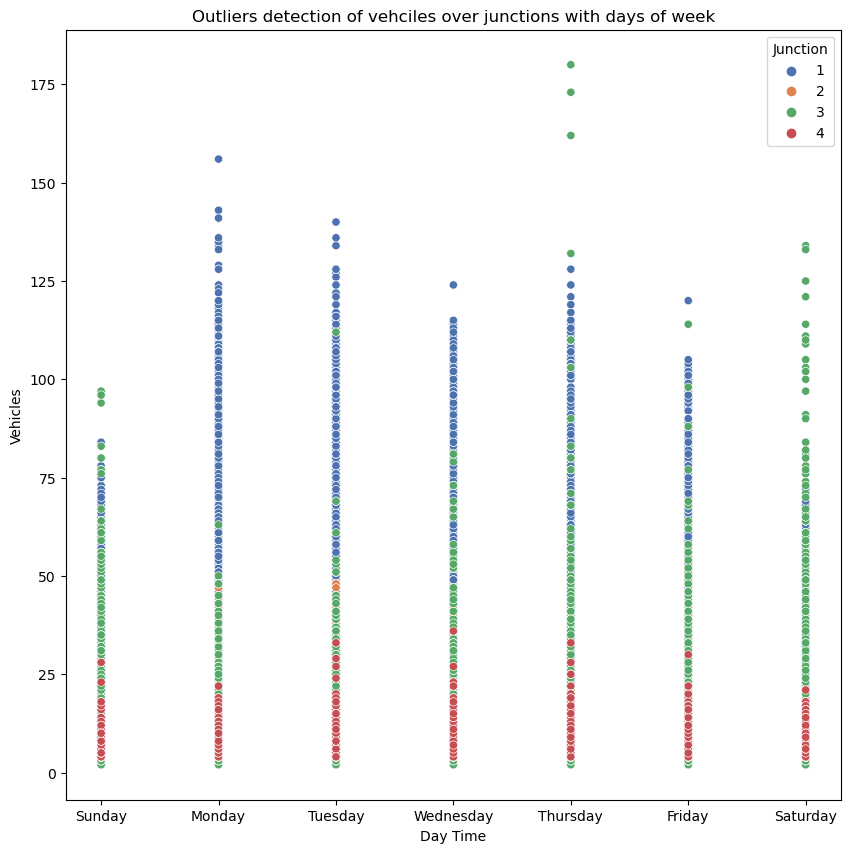

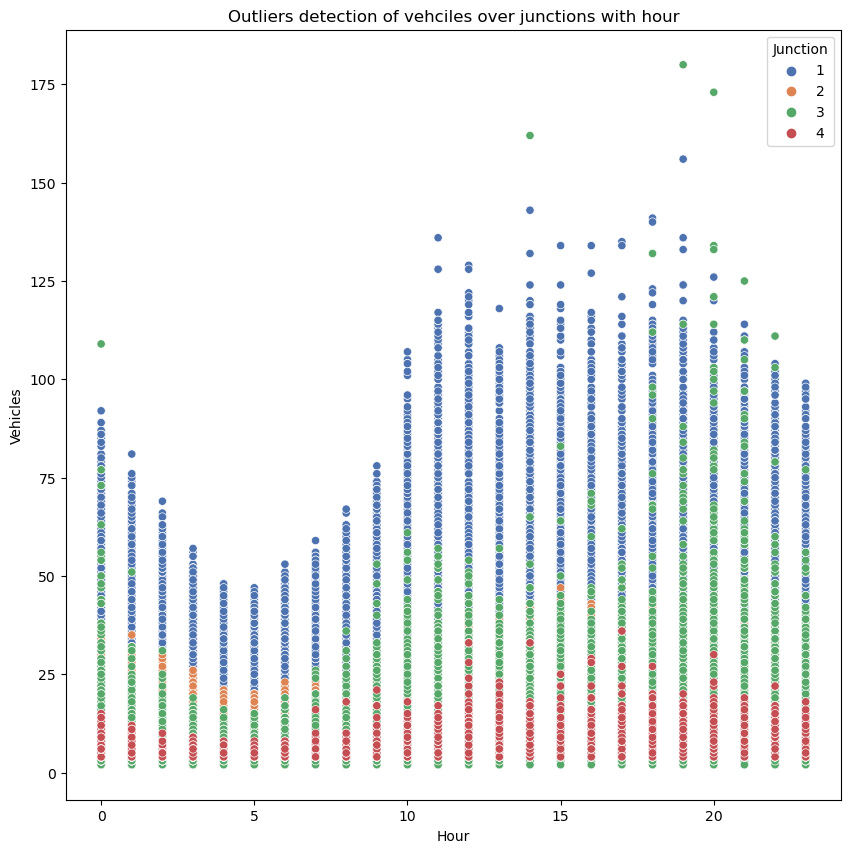

In [31]:
outliers['day_of_week'] = outliers['DateTime'].dt.day_name()
outliers['hour'] = outliers['DateTime'].dt.hour

## By hour and days
plt.figure(figsize  = (10,10))
sns.scatterplot(x = 'day_of_week', y = 'Vehicles', data = outliers, hue = 'Junction', palette = 'deep')
plt.title('Outliers detection of vehciles over junctions with days of week')
plt.xlabel('Day Time')
plt.ylabel('Vehicles')
plt.show()


plt.figure(figsize  = (10,10))
sns.scatterplot(x = 'hour', y = 'Vehicles', data = outliers, hue = 'Junction', palette = 'deep')
plt.title('Outliers detection of vehciles over junctions with hour')
plt.xlabel('Hour')
plt.ylabel('Vehicles')
plt.show()


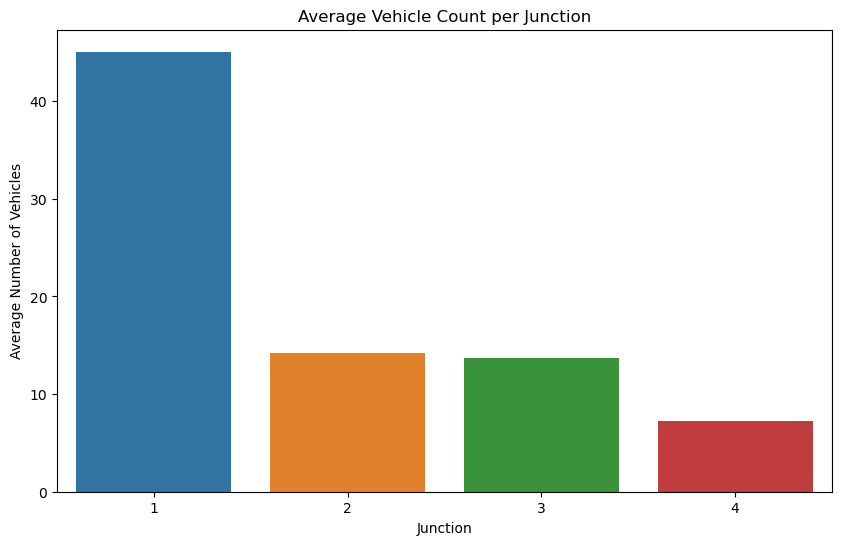

In [33]:
plt.figure(figsize=(10, 6))
avg_vehicles = df.groupby('Junction')['Vehicles'].mean().reset_index()
sns.barplot(x='Junction', y='Vehicles', data=avg_vehicles)
plt.title('Average Vehicle Count per Junction')
plt.xlabel('Junction')
plt.ylabel('Average Number of Vehicles')
plt.show()

In [37]:
df.sample(3)

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
23340,2016-10-30 12:00:00,2,8,20161030122,2016,10,30,12,Sunday
2612,2016-02-17 20:00:00,1,48,20160217201,2016,2,17,20,Wednesday
32574,2016-03-21 06:00:00,3,7,20160321063,2016,3,21,6,Monday


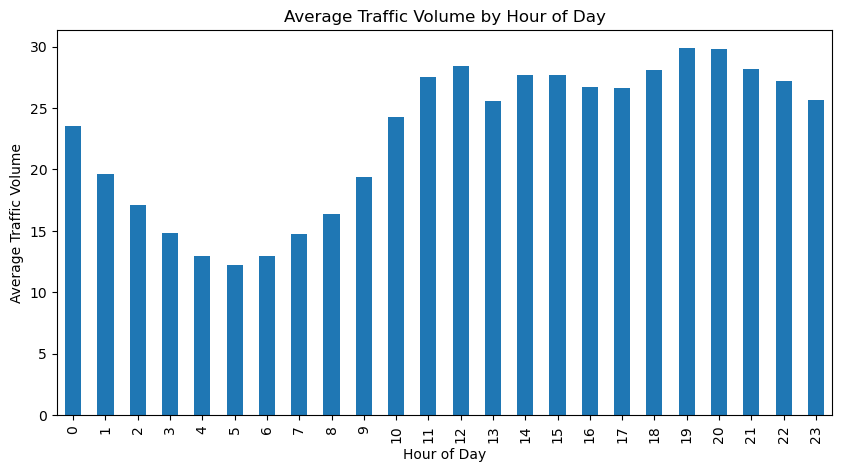

In [46]:
plt.figure(figsize=(10, 5))
avg_traffic_by_hour = df.groupby('Hour')['Vehicles'].mean()
avg_traffic_by_hour.plot(kind='bar')
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.show()

In [54]:
df['date_offset'] = (df.DateTime.dt.month*100 + df.DateTime.dt.day - 320)%1300
df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])


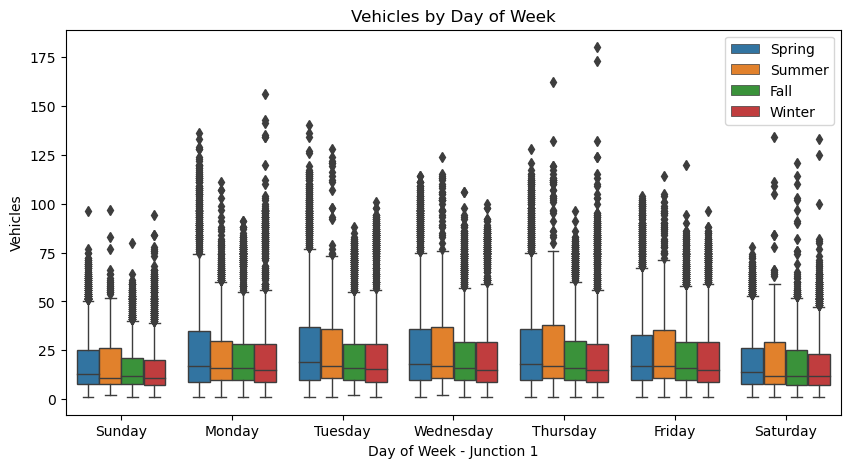

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df.dropna(),
            x='Day',
            y='Vehicles',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Vehicles by Day of Week')
ax.set_xlabel('Day of Week - Junction 1')
ax.set_ylabel('Vehicles')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

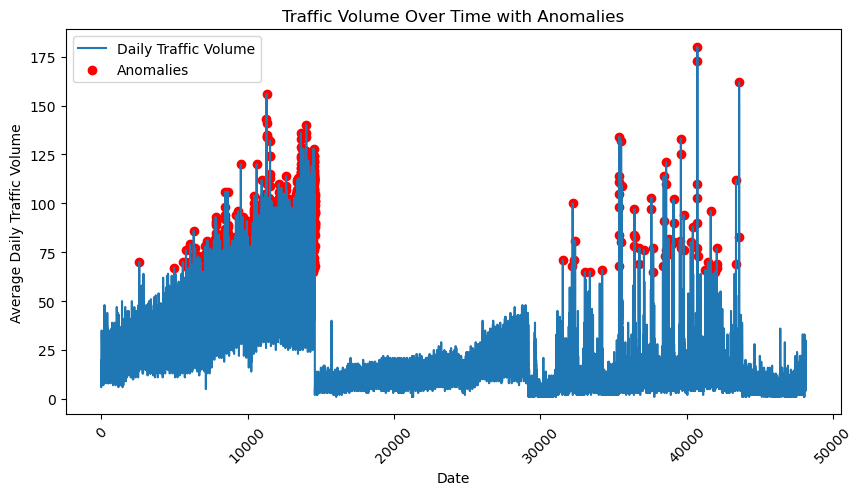

In [95]:
df['z_score'] = (df['Vehicles'] - df['Vehicles'].mean()) / df['Vehicles'].std()

# Identify days where the Z-score is above a certain threshold (e.g., 2 or -2 for significant anomalies)
anomalies = df[abs(df['z_score']) > 2]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Vehicles'], label='Daily Traffic Volume')
plt.scatter(anomalies.index, anomalies['Vehicles'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Traffic Volume')
plt.title('Traffic Volume Over Time with Anomalies')
plt.legend()
plt.show()

In [109]:
df

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day,date_offset,season,z_score
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday,781,Fall,-0.375485
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday,781,Fall,-0.471870
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday,781,Fall,-0.616448
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday,781,Fall,-0.761026
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday,781,Fall,-0.664641
...,...,...,...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday,310,Summer,-0.568255
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday,310,Summer,0.347405
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday,310,Summer,-0.327292
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday,310,Summer,-0.038136


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     48120 non-null  datetime64[ns]
 1   Junction     48120 non-null  int64         
 2   Vehicles     48120 non-null  int64         
 3   ID           48120 non-null  int64         
 4   Year         48120 non-null  int32         
 5   Month        48120 non-null  int32         
 6   Date_no      48120 non-null  int32         
 7   Hour         48120 non-null  int32         
 8   Day          48120 non-null  object        
 9   date_offset  48120 non-null  int32         
 10  season       47952 non-null  category      
 11  z_score      48120 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int32(5), int64(3), object(1)
memory usage: 3.2+ MB


In [198]:
df_train_prophet = df.reset_index().rename(columns={'DateTime': 'ds', 'Vehicles': 'y'})
df_train_prophet.head()

,index,ds,Junction,y,ID,Year,Month,Date_no,Hour,Day,date_offset,season,z_score
0,0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday,781,Fall,-0.375485
1,1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday,781,Fall,-0.471870
2,2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday,781,Fall,-0.616448
3,3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday,781,Fall,-0.761026
4,4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday,781,Fall,-0.664641


In [212]:
train_df=df_train_prophet[['ds','y']][:3000]

In [214]:
train_df

,ds,y
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9
...,...,...
2995,2016-03-04 19:00:00,46
2996,2016-03-04 20:00:00,38
2997,2016-03-04 21:00:00,37
2998,2016-03-04 22:00:00,32


In [220]:
test_df=df_train_prophet[3000:]

In [226]:
test_df

,index,ds,Junction,y,ID,Year,Month,Date_no,Hour,Day,date_offset,season,z_score
3000,3000,2016-03-05 00:00:00,1,32,20160305001,2016,3,5,0,Saturday,1285,Winter,0.443790
3001,3001,2016-03-05 01:00:00,1,28,20160305011,2016,3,5,1,Saturday,1285,Winter,0.251019
3002,3002,2016-03-05 02:00:00,1,23,20160305021,2016,3,5,2,Saturday,1285,Winter,0.010056
3003,3003,2016-03-05 03:00:00,1,22,20160305031,2016,3,5,3,Saturday,1285,Winter,-0.038136
3004,3004,2016-03-05 04:00:00,1,20,20160305041,2016,3,5,4,Saturday,1285,Winter,-0.134522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48115,48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday,310,Summer,-0.568255
48116,48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday,310,Summer,0.347405
48117,48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday,310,Summer,-0.327292
48118,48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday,310,Summer,-0.038136


In [228]:
%%time
model = Prophet()
model.fit(train_df)

11:14:07 - cmdstanpy - INFO - Chain [1] start processing
11:14:08 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 391 ms
Wall time: 1.92 s


In [230]:
test_df = test_df.reset_index() \
    .rename(columns={'DateTime':'ds',
                     'Vehicles':'y'})
df_test_fcst = model.predict(test_df)
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-11-01 00:00:00,19.098870,5.411570,16.624967,19.098870,19.098870,-7.756224,-7.756224,-7.756224,-0.025859,-0.025859,-0.025859,-7.730365,-7.730365,-7.730365,0.0,0.0,0.0,11.342646
1,2015-11-01 00:00:00,19.098870,5.629406,17.008082,19.098870,19.098870,-7.756224,-7.756224,-7.756224,-0.025859,-0.025859,-0.025859,-7.730365,-7.730365,-7.730365,0.0,0.0,0.0,11.342646
2,2015-11-01 01:00:00,19.103603,2.945979,14.056301,19.103603,19.103603,-10.538523,-10.538523,-10.538523,-2.698885,-2.698885,-2.698885,-7.839638,-7.839638,-7.839638,0.0,0.0,0.0,8.565080
3,2015-11-01 01:00:00,19.103603,2.835338,14.334586,19.103603,19.103603,-10.538523,-10.538523,-10.538523,-2.698885,-2.698885,-2.698885,-7.839638,-7.839638,-7.839638,0.0,0.0,0.0,8.565080
4,2015-11-01 02:00:00,19.108337,0.278246,11.734355,19.108337,19.108337,-13.128395,-13.128395,-13.128395,-5.210929,-5.210929,-5.210929,-7.917466,-7.917466,-7.917466,0.0,0.0,0.0,5.979942
